# Speed distributions $f(v)$ for each shard as well as our composite model


In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 300
v = linspace(0.01,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 



# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)

weights = weights*(flipud(arange(1,size(pops)+1))**2.0)
#weights[0] = weights[0]*2.0
#weights[1] = weights[1]/2.0
weights /= sum(weights)


# Smooth cutoff or sharp cutoff?
SCO = True
# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Triaxial(v,day,sig_iso) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta,SmoothCutoff=SCO) # Sausage
fv_Iso_gf = SpeedDist_Triaxial(v,day,sig_iso,GravFocus=True,SmoothCutoff=SCO) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True,SmoothCutoff=SCO) # Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,day,sig_iso,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,day,sig_beta,GalFrame=True,SmoothCutoff=SCO) # Galactic frame Sausage


v_s = velocities[0,:]
sig_s = dispersions[0,:]
fv_lab = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
fv_gal = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True)
fv_gf = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True) # Focused
shard_label = ['S1']
shard_weights = weights[0]
for i in range(1,nshards):
    if names[i].endswith('a'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        
        v_s = velocities[i+1,:]
        sig_s = dispersions[i+1,:]
        fv_lab1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        shard_label.append(names[i][:-1])
        shard_weights = append(shard_weights,weights[i]+weights[i+1])
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gal = vstack((fv_gal,fv_gal1))
        fv_gf = vstack((fv_gf,fv_gf1))
        
    elif not names[i].endswith('b'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,SmoothCutoff=SCO)
        fv_gal1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,SmoothCutoff=SCO) 
        shard_label.append(names[i])
        shard_weights = append(shard_weights,weights[i])
        
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gal = vstack((fv_gal,fv_gal1))
        fv_gf = vstack((fv_gf,fv_gf1))

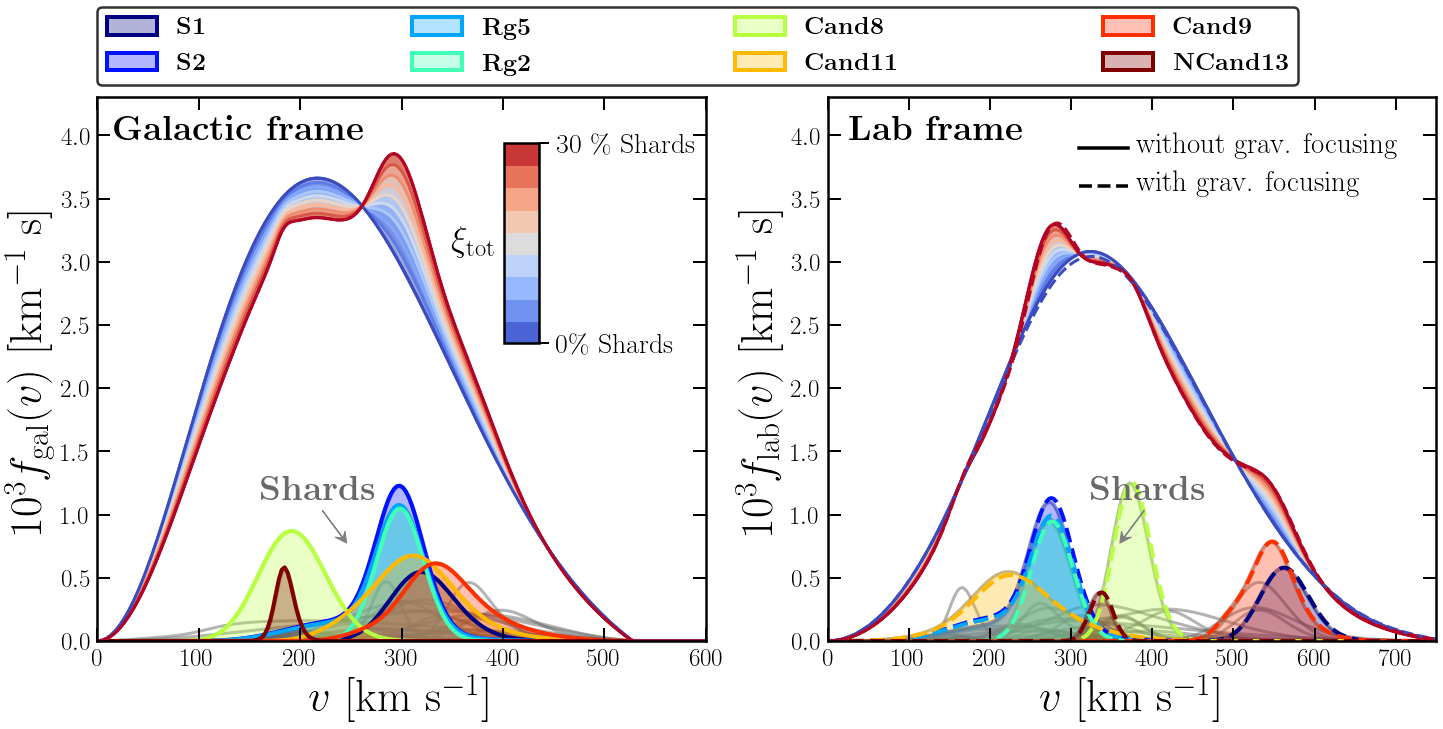

In [2]:
import matplotlib.cm as cm

# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab1 = r"$10^3 f_{\rm gal}(v)$ [km$^{-1}$ s]"
ylab2 = ylab1.replace('gal','lab')
fig,ax1,ax2 = MyDoublePlot(xlab,ylab1,xlab,ylab2,size_x=24,size_y=10,wspace=0.2)

# Smooth component
eta_saus = 0.2
fv0_gal = (1-eta_saus)*fv_Iso_gal + eta_saus*fv_Saus_gal
fv0_lab = (1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab
fv0_gf = (1-eta_saus)*fv_Iso_gf + eta_saus*fv_Saus_gf


nshards = shape(shard_label)[0]


# Shards with varying xi
n_xi = 10
xi_max = 0.2
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2_lab = 1e3*(xi_vals[-1]*sum(fv_lab,0)+(1.0-xi_vals[-1])*fv0_lab)
y2_gal = 1e3*(xi_vals[-1]*sum(fv_gal,0)+(1.0-xi_vals[-1])*fv0_gal)
y2_gf = 1e3*(xi_vals[-1]*sum(fv_gf,0)+(1.0-xi_vals[-1])*fv0_gf)
fvs_lab = sum(fv_lab,0)
fvs_gf = sum(fv_gf,0)
fvs_gal = sum(fv_gal,0)
for i in range(0,n_xi):
    xi = xi_vals[i]
    ax1.fill_between(v,1e3*(xi*fvs_gal+(1-xi)*fv0_gal),y2=y2_gal,color=col[i,:],alpha=0.5)
    ax1.plot(v,1e3*(xi*fvs_gal+(1-xi)*fv0_gal),'-',color=col[i,:],linewidth=3)
    
    ax2.fill_between(v,1e3*(xi*fvs_lab+(1-xi)*fv0_lab),y2=y2_lab,color=col[i,:],alpha=0.5)
    ax2.plot(v,1e3*(xi*fvs_lab+(1-xi)*fv0_lab),'-',color=col[i,:],linewidth=3)
    
    
# Range
ax1.plot(v,1e3*fv0_gal,'-',color=col[0,:],linewidth=3)
ax1.plot(v,y2_gal,'-',color=col[-1,:],linewidth=3)
ax2.plot(v,1e3*fv0_lab,'-',color=col[0,:],linewidth=3)
ax2.plot(v,y2_lab,'-',color=col[-1,:],linewidth=3)
ax2.plot(v,1e3*fv0_gf,'--',color=col[0,:],linewidth=3)
ax2.plot(v,y2_gf,'--',color=col[-1,:],linewidth=3)



# second "legend" for with/without GF
ax2.plot([310,370],[3.9,3.9], 'k-',linewidth=3.5)
ax2.plot([310,370],[3.6,3.6], 'k--',linewidth=3.5)
ax2.text(380,3.9-0.038,'without grav. focusing',fontsize=29)
ax2.text(380,3.6-0.038,'with grav. focusing',fontsize=29)

# Plot individual streams
#ax1.plot(v,1e3*fvs_gal/2,'g-',lw=3)
#ax2.plot(v,1e3*fvs_lab/2,'g-',lw=3)
for i in range(0,nshards):
    ax1.plot(v,1e3*fv_gal[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=0) 
    ax2.plot(v,1e3*fv_lab[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=0)



nex = 8
#sortw = argsort(shard_weights)
sortw = argsort(amax(fv_gal,axis=1))
Examples = [shard_label[i] for i in flipud(sortw[-(nex):])]
if 'S1' in Examples:
    Examples.remove('S1')
    Examples = append('S1',Examples)
else:
    Examples = append('S1',Examples)
    Examples = Examples[0:-1]

import cmocean
col_ex = (cm.jet(linspace(0,1,size(Examples))))
alph= 0.3
for i in range(0,size(Examples)):
    j = shard_label.index(Examples[i])
    ax1.fill_between(v,1e3*fv_gal[j,:],color=col_ex[i,:],lw=4,alpha=alph,zorder=1) 
    ax1.plot(v,1e3*fv_gal[j,:],color=col_ex[i,:],lw=4,zorder=1) 
    ax1.fill_between([-1,-1],[-1,-3],facecolor=col_alpha(col_ex[i,:],alpha=alph),edgecolor=col_ex[i,:],lw=4,label=r'{\bf '+Examples[i]+r'}',zorder=1)
    
    ax2.fill_between(v,1e3*fv_lab[j,:],color=col_ex[i,:],lw=4,alpha=alph,zorder=1) 
    ax2.plot(v,1e3*fv_gf[j,:],'--',color=col_ex[i,:],lw=4,zorder=1)

# Legend lines
leg = ax1.legend(loc='upper left',fontsize=25,edgecolor='k',ncol=4,bbox_to_anchor=(-0.02, 1.19), columnspacing=8.19)
leg.get_frame().set_linewidth(2.5)
 
    
# Plot fiddling
ax1.set_xlim(left=0,right=600.0)
ax1.set_ylim(bottom=0,top=4.3)
ax2.set_xlim(left=0,right=750.0)
ax2.set_ylim(bottom=0,top=4.3)
plt.gcf().text(0.70,0.32,r'{\bf Shards}',fontsize=35,color='dimgray')
plt.gcf().text(0.22,0.32,r'{\bf Shards}',fontsize=35,color='dimgray')
plt.gcf().text(0.135,0.82,r'{\bf Galactic frame}',fontsize=35,color='k')
plt.gcf().text(0.56,0.82,r'{\bf Lab frame}',fontsize=35,color='k')

ax1.arrow(0.37, 0.24, 0.04, -0.06, transform=ax1.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')
ax2.arrow(0.52, 0.24, -0.04, -0.06, transform=ax2.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax1, width="5%", height="50%", bbox_to_anchor=[-30, 200, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.33,0.66,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_fv'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

292809
3073
/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log



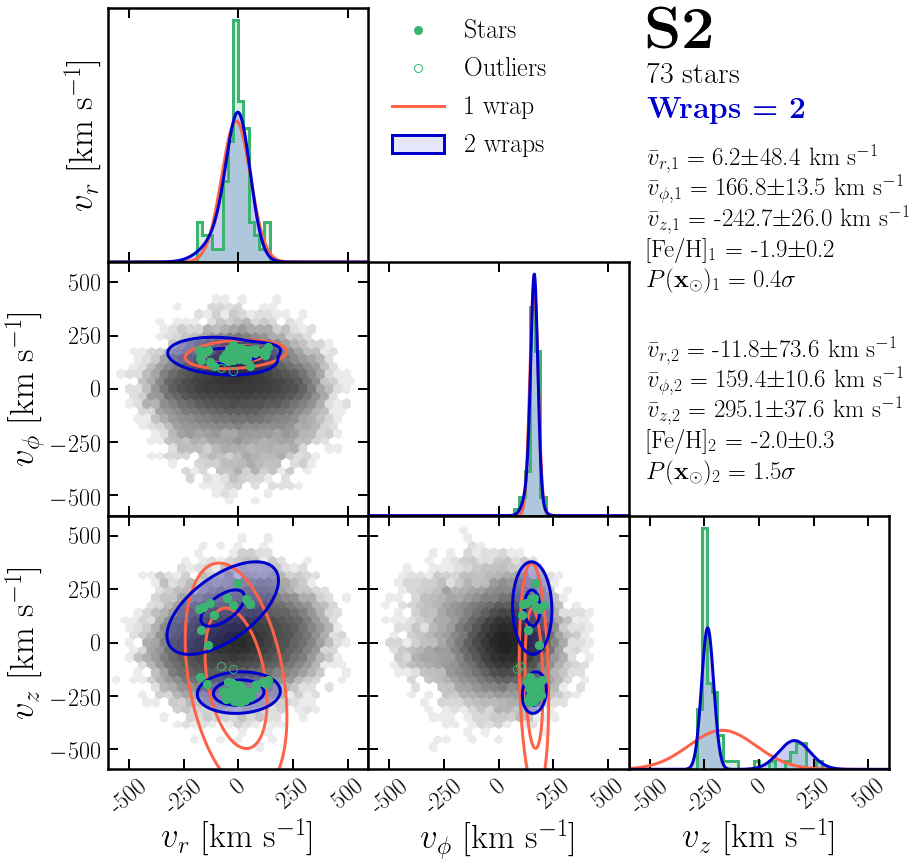

In [40]:
def fv_1D(vfine,clf,i):
    covs = clf.covariances_
    meens = clf.means_
    ws = clf.weights_

    fv = zeros(shape=shape(vfine))
    if ndim(covs)>2:
        for k in range(0,shape(covs)[0]):
            U = squeeze(linalg.inv(covs[k,:,:]))
            U0 = U[i,i]
            V = U[i,:]    
            V = delete(V, i, axis=0)
            W = delete(U, i, axis=0)
            W = delete(W, i, axis=1)
            U = U0 - linalg.multi_dot([V, linalg.inv(W), V.T])
            
            v0 = meens[k,i]
            #Norm = (1.0/sqrt(2*pi))*sqrt(linalg.det(W))
            Norm = 1.0
            fv += ws[k]*Norm*exp(-0.5*(vfine-v0)*U*(vfine-v0))
            #if (shape(covs)[0])==2:
            #    print k,U,U0,linalg.multi_dot([V, linalg.inv(W), V.T])
            #    print '----'
    else:
        # If diagonal just use normal formula
        sig0_sq = covs[0,i]
        v0 = meens[0,i]
        Norm = (1.0/sqrt(2*pi*sig0_sq))
        fv = Norm*exp(-(vfine-v0)**2.0/(2*sig0_sq))
    fv /= trapz(fv,vfine)
    return fv


def fv_2D(V1,V2,clf,i,j):
    # see http://www-biba.inrialpes.fr/Jaynes/cappe1.pdf
    covs = clf.covariances_
    meens = clf.means_
    ws = clf.weights_
    fv = zeros(shape=shape(V1))
    if ndim(covs)>2:
        for k in range(0,shape(covs)[0]):
            U = squeeze(linalg.inv(covs[k,:,:]))
            v10 = meens[k,i]
            v20 = meens[k,j]
            U0 = array([[U[i,i],U[i,j]],[U[j,i],U[j,j]]])
            V = vstack((U[i,:],U[j,:]))    
            V = delete(V, (i,j), axis=1)

            W = delete(U, (i,j), axis=0)
            W = delete(W, (i,j), axis=1)
            Uoff = linalg.multi_dot([V, linalg.inv(W), V.T])
            Ut = U0-Uoff
            V1o = V1-v10
            V2o = V2-v20
            #Norm = (1.0/sqrt(2*pi))*sqrt(linalg.det(W))  
            Norm = 1.0
            fv += ws[k]*Norm*exp(-0.5*(V1o**2.0*Ut[0,0]+V2o**2.0*Ut[1,1]+2*V1o*V2o*Ut[1,0]))  
    else:
        v10 = meens[0,i]
        v20 = meens[0,j]
        Sig_inv = 1.0/covs
        V1o = V1-v10
        V2o = V2-v20
        Norm = sqrt(Sig_inv[0,j]*Sig_inv[0,i])/(2*pi)
        fv = Norm*exp(-0.5*(V1o**2.0*Sig_inv[0,i]+V2o**2.0*Sig_inv[0,j]))
    fv = log(fv)
    fv = fv-amax(fv)
    return fv


def FitStars(Cand,RemoveOutliers = False,z_th = 6.0):
    # Get data
    name = Cand.group_id.unique()[0]
    nstars = size(Cand,0)
    feh = Cand.feh # metallicity
    vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel # velocities
    x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ # positions
    #x,y,z = Cand.GalR,Cand.Galphi,Cand.Galz # positions


    # Remove outliers if needed
    if RemoveOutliers and (nstars>15):
        x_red,y_red,z_red,vx_red,vy_red,vz_red,feh_red = RemovePhaseSpaceOutliers(x,y,z,vx,vy,vz,feh,z_th=z_th)
        data = array([x_red,y_red,z_red,vx_red,vy_red,vz_red,feh_red]).T
        nstars = size(x_red)  
    else:
        data = array([x,y,z,vx,vy,vz,feh]).T

    
    # Set up three models
    clfa = mixture.GaussianMixture(n_components=1, covariance_type='diag')
    clfb = mixture.GaussianMixture(n_components=1, covariance_type='full')
    clfc = mixture.GaussianMixture(n_components=2, covariance_type='full')

    # Fit data to each
    clfa.fit(data)
    clfb.fit(data)
    clfc.fit(data)  
    return data,clfa,clfb,clfc

def ResampleLocalStars(clf,Psun,v_meens,v_covs):
     # Local stars
    dataf = clf.sample(5e6)
    probsf = clf.predict_proba(dataf[0][:,:])
    distf = sqrt((Sun[0]-dataf[0][:,0])**2.0+(Sun[1]-dataf[0][:,1])**2.0+(Sun[2]-dataf[0][:,2])**2.0)

    #xf = dataf[0][:,0]*cos(dataf[0][:,1])
    #yf = dataf[0][:,0]*sin(dataf[0][:,1])
    #zf = dataf[0][:,2]
    #distf = sqrt((Sun_cyl[0]-xf)**2.0+(Sun_cyl[1]-yf)**2.0+(Sun_cyl[2]-zf)**2.0)
    
    
    if size(Psun)>1:
        probs = Psun
    else:
        probs = array([Psun])
        
    i = 0
    v_meens1 = zeros(shape=shape(v_meens))
    v_covs1 = zeros(shape=shape(v_covs))
    for psun in probs:
        if psun<1.5:
            mask = (distf<1.0)*(argmax(probsf,axis=1)==i)
            print(sum(mask))
            vxf = dataf[0][mask,3]
            vyf = dataf[0][mask,4]
            vzf = dataf[0][mask,5]
            #hx,vb = histogram(vxf,range=[vmin,vmax],bins=nbins_1D,normed=True)
            #hy,_  = histogram(vyf,range=[vmin,vmax],bins=nbins_1D,normed=True)
            #hz,_  = histogram(vzf,range=[vmin,vmax],bins=nbins_1D,normed=True)
            #vc = (vb[0:-1]+vb[1:])/2.0
            #ax_x.plot(vc,hx,'y-',lw=3)
            #ax_y.plot(vc,hy,'y-',lw=3)
            #ax_z.plot(vc,hz,'y-',lw=3)
            #print(i,'vx = ',mean(vxf),' ± ',std(vxf))
            #print(i,'vy = ',mean(vyf),' ± ',std(vyf))
            #print(i,'vz = ',mean(vzf),' ± ',std(vzf))
            v_meens1[i,:] = array([mean(vxf),mean(vyf),mean(vzf)])
            v_covs1[i,:,:] = cov(vstack((vxf,vyf,vzf)))
            if sum(v_meens1[i,:])==nan or sum(v_covs1[i,:,:])==nan:
                v_meens1[i,:] = v_meens[i,:]
                v_covs1[i,:,:] = v_covs[i,:,:]
        else:
            v_meens1[i,:] = v_meens[i,:]
            v_covs1[i,:,:] = v_covs[i,:,:]
        i += 1
    return v_meens1,v_covs1
    
def CountWraps(data,clfb,clfc):
    nstars = size(data,0)

    # Choose model
    bics = array([0.0,0.0,0.0])
    #bics[0] = clfa.bic(data)
    #bics[1] = clfb.bic(data)
    #bics[2] = clfc.bic(data)
    # check if groups overlap and bimodal is overfitting
    #if argmin(bics)==2:
    covs = clfc.covariances_
    meens = clfc.means_
    chck = 0
    for k in range(3,6):
        dsig = 2.5*sqrt(covs[0,k,k])+2.5*sqrt(covs[1,k,k])
        dv = abs(meens[0,k]-meens[1,k])
        if dv>dsig:
            chck += 1
            
    if chck==0:
        bics[1] = -10000.0
    else:
        bics[2] = -10000.0
                  
    if (argmin(bics)==0) or (argmin(bics)==1) or (nstars<10):
        covs = clfb.covariances_
        meens = clfb.means_
        fehs = array([meens[0,6],sqrt(covs[0,6,6])])
        pops = shape(data)[0]
        
        x_meens = meens[:,0:3]
        x_covs = covs[:,0:3,0:3]
        Psun = SunProb(x_meens,x_covs)
        v_meens,v_covs = ResampleLocalStars(clfb,Psun,meens[:,3:6],covs[:,3:6,3:6])
        
    else:
        covs = clfc.covariances_
        meens = clfc.means_
   
        vv1 = meens[0,3:6]
        vv2 = meens[1,3:6]
        r1 = sqrt((data[:,3]-vv1[0])**2.0+(data[:,4]-vv1[1])**2.0+(data[:,5]-vv1[2])**2.0)
        r2 = sqrt((data[:,3]-vv2[0])**2.0+(data[:,4]-vv2[1])**2.0+(data[:,5]-vv2[2])**2.0)
        pops_both = array([sum(r1<r2),sum(r2<r1)])
        if pops_both[0]<3.0:
            data_red = data[r2<r1,:]
            clf_red = mixture.GaussianMixture(n_components=1, covariance_type='full')
            clf_red.fit(data_red)
            covs = clf_red.covariances_
            meens = clf_red.means_
            pops = pops_both[1]
            fehs = array([meens[0,6],sqrt(covs[0,6,6])])
            x_meens = meens[:,0:3]
            x_covs = covs[:,0:3,0:3]
            Psun = SunProb(x_meens,x_covs)
            v_meens,v_covs = ResampleLocalStars(clfc,Psun,meens[:,3:6],covs[:,3:6,3:6])
        elif pops_both[1]<3.0:
            data_red = data[r1<r2,:]
            clf_red = mixture.GaussianMixture(n_components=1, covariance_type='full')
            clf_red.fit(data_red)
            covs = clf_red.covariances_
            meens = clf_red.means_
            pops = pops_both[0]
            fehs = array([meens[0,6],sqrt(covs[0,6,6])])
            x_meens = meens[:,0:3]
            x_covs = covs[:,0:3,0:3]
            Psun = SunProb(x_meens,x_covs)
            v_meens,v_covs = ResampleLocalStars(clfc,Psun,meens[:,3:6],covs[:,3:6,3:6])
        else:
            fehs = zeros(shape=(2,2))
            fehs[0,:] = array([meens[0,6],sqrt(covs[0,6,6])])
            fehs[1,:] = array([meens[1,6],sqrt(covs[1,6,6])])
            pops = pops_both  
            x_meens = meens[:,0:3]
            x_covs = covs[:,0:3,0:3]
            Psun = SunProb(x_meens,x_covs)
            v_meens,v_covs = ResampleLocalStars(clfc,Psun,meens[:,3:6],covs[:,3:6,3:6])
        
    return x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun


def VelocityTriangle1(Cand,vmin=-595.0,vmax=595.0,nfine=500,nbins_1D = 50,\
                            levels=[-6.2,-2.3,0],\
                            tit_fontsize=30,\
                            z_th = 6.0,\
                            RemoveOutliers = False,\
                            cmap=cm.Greens,\
                            col_hist='mediumseagreen',\
                            colp = 'mediumseagreen',\
                            col_a = 'purple',\
                            col_b = 'tomato',\
                            col_c = 'mediumblue',\
                            point_size = 8,\
                            lblsize = 31,\
                            xlblsize = 35,\
                            def_alph = 0.2,\
                            SaveFigure = True,\
                            PlotFullSample=False):

    
    ######
    name = Cand.group_id.unique()[0]
    nstars = size(Cand,0)
    vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel
    x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ
    feh = Cand.feh
    x_red,y_red,z_red,vx_red,vy_red,vz_red,feh_red = RemovePhaseSpaceOutliers(x,y,z,vx,vy,vz,feh,z_th=6)


    # Fit stars
    data,clfa,clfb,clfc = FitStars(Cand,RemoveOutliers=RemoveOutliers,z_th=z_th)

    # Choose Model
    
    
    x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = CountWraps(data,clfb,clfc)
    
    vfine = linspace(vmin,vmax,nfine)
    V1,V2 = meshgrid(vfine,vfine)

    # Set plot rc params
    plt.rcParams['axes.linewidth'] = 2.5
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, axarr = plt.subplots(3, 3,figsize=(14,14))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.0,hspace=0.0)
    ax_x = plt.subplot(gs[0,0])
    ax_y = plt.subplot(gs[1,1])
    ax_z = plt.subplot(gs[2,2])

    ax_yx = plt.subplot(gs[1,0])
    ax_zx = plt.subplot(gs[2,0])
    ax_zy = plt.subplot(gs[2,1])

    fig.delaxes(plt.subplot(gs[0,1]))
    fig.delaxes(plt.subplot(gs[0,2]))
    fig.delaxes(plt.subplot(gs[1,2]))

    # 1D plots
    plt.sca(ax_x)
    ax_x.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,density=True,stacked=True)
    plt.hist(vx,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',density=True,stacked=True)
    plt.plot(vfine,fv_1D(vfine,clfb,3),'-',linewidth=3,color=col_b)
    plt.plot(vfine,fv_1D(vfine,clfc,3),'-',linewidth=3,color=col_c)
    plt.ylabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)

    plt.sca(ax_y)
    ax_y.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,density=True,stacked=True)
    plt.hist(vy,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',density=True,stacked=True)
    plt.plot(vfine,fv_1D(vfine,clfb,4),'-',linewidth=3,color=col_b)
    plt.plot(vfine,fv_1D(vfine,clfc,4),'-',linewidth=3,color=col_c)

    plt.sca(ax_z)
    ax_z.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,alpha=def_alph,density=True,stacked=True)
    plt.hist(vz,range=[vmin,vmax],bins=nbins_1D,color=col_hist,linewidth=3,histtype='step',density=True,stacked=True)
    plt.plot(vfine,fv_1D(vfine,clfb,5),'-',linewidth=3,color=col_b)
    plt.plot(vfine,fv_1D(vfine,clfc,5),'-',linewidth=3,color=col_c)
    plt.xlabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)


    # 2D plots
    plt.sca(ax_yx)
    ax_yx.plot(vx_red,vy_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp,label='Stars')
    ax_yx.plot(vx,vy,'o',markersize=point_size,markerfacecolor='none',markeredgecolor=colp,label='Outliers')
    ax_yx.contour(vfine,vfine,fv_2D(V1,V2,clfb,3,4),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
    ax_yx.contour(vfine,vfine,fv_2D(V1,V2,clfc,3,4),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
    plt.ylabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)

    plt.sca(ax_zx)
    ax_zx.plot(vx_red,vz_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp)
    ax_zx.plot(vx,vz,'o',markersize=point_size,markerfacecolor='none',markeredgecolor=colp)
    ax_zx.contour(vfine,vfine,fv_2D(V1,V2,clfb,3,5),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
    ax_zx.contour(vfine,vfine,fv_2D(V1,V2,clfc,3,5),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
    plt.xlabel(r'$v_r$ [km s$^{-1}$]',fontsize=xlblsize)
    plt.ylabel(r'$v_z$ [km s$^{-1}$]',fontsize=xlblsize)

    plt.sca(ax_zy)
    ax_zy.plot(vy_red,vz_red,'o',markersize=point_size,markerfacecolor=colp,markeredgecolor=colp)
    ax_zy.plot(vy,vz,'o',markersize=point_size,markerfacecolor='none',markeredgecolor=colp)
    ax_zy.contour(vfine,vfine,fv_2D(V1,V2,clfb,4,5),levels=levels,colors=col_b,linewidths=3,linestyles='solid')
    ax_zy.contour(vfine,vfine,fv_2D(V1,V2,clfc,4,5),levels=levels,colors=col_c,linewidths=3,linestyles='solid')
    plt.xlabel(r'$v_\phi$ [km s$^{-1}$]',fontsize=xlblsize)

    # Tick style
    ax_x.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
    ax_y.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
    ax_z.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
    ax_zx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
    ax_yx.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)
    ax_zy.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=7,labelsize=24)

    # fix x-ticks
    vtx = array([-500,-250,0,250,500])
    ax_zx.set_xticks(vtx)
    ax_zy.set_xticks(vtx)
    ax_z.set_xticks(vtx)
    ax_zx.set_xticklabels(vtx,rotation=40)
    ax_zy.set_xticklabels(vtx,rotation=40)
    ax_z.set_xticklabels(vtx,rotation=40)
    
    # Limits and removing ticks
    ax_yx.set_xlim([vmin,vmax])
    ax_yx.set_ylim([vmin,vmax])
    ax_zx.set_xlim([vmin,vmax])
    ax_zx.set_ylim([vmin,vmax])
    ax_zy.set_xlim([vmin,vmax])
    ax_zy.set_ylim([vmin,vmax])
    ax_x.set_xlim([vmin,vmax])
    ax_y.set_xlim([vmin,vmax])
    ax_z.set_xlim([vmin,vmax])
    ax_x.set_yticks([])
    ax_y.set_yticks([])
    ax_z.set_yticks([])
    ax_x.set_yticklabels([])
    ax_x.set_xticklabels([])
    ax_y.set_yticklabels([])
    ax_y.set_xticklabels([])
    ax_z.set_yticklabels([])
    ax_yx.set_xticklabels([])
    ax_zy.set_yticklabels([])


    # Label for name and number of stars
    xlab = 0.66
    plt.gcf().text(xlab, 0.84, r'\bf {'+name+r'}', fontsize=60)
    plt.gcf().text(xlab,0.805,str(nstars)+' stars',fontsize=30)
                  
 
    label_b = '1 wrap'
    label_c = '2 wraps'
    if size(Psun)==1:
        ax_x.fill_between(vfine,fv_1D(vfine,clfb,3),facecolor=col_b,alpha=def_alph,zorder=-5)
        ax_y.fill_between(vfine,fv_1D(vfine,clfb,4),facecolor=col_b,alpha=def_alph,zorder=-5)
        ax_z.fill_between(vfine,fv_1D(vfine,clfb,5),facecolor=col_b,alpha=def_alph,zorder=-5)
        ax_yx.contourf(vfine,vfine,fv_2D(V1,V2,clfb,3,4),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)
        ax_zx.contourf(vfine,vfine,fv_2D(V1,V2,clfb,3,5),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)
        ax_zy.contourf(vfine,vfine,fv_2D(V1,V2,clfb,4,5),levels=levels,colors=col_b,alpha=def_alph,zorder=-5)

        
        
        plt.sca(ax_yx)
        ax_yx.fill_between(-10000*vfine/vfine,-1000*vfine/vfine,\
                           y2=-10000,lw=3,edgecolor=col_b,facecolor=col_alpha(col_b),label=label_b,zorder=-1)
        ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_c,label=label_c,zorder=5)
        plt.gcf().text(xlab,0.77,r'{\bf Wraps = 1}',fontsize=30,color=col_b) 
    
        plt.gcf().text(xlab,0.72,r'$\bar{v}_r $ = '\
                       +'{:.1f}'.format(v_meens[0,0])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,0,0]))\
                       +' km s$^{-1}$',fontsize=25)           
        plt.gcf().text(xlab,0.69,r'$\bar{v}_\phi $ = '\
                       +'{:.1f}'.format(v_meens[0,1])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,1,1]))\
                       +' km s$^{-1}$',fontsize=25)            
        plt.gcf().text(xlab,0.66,r'$\bar{v}_z $ = '\
                       +'{:.1f}'.format(v_meens[0,2])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,2,2]))\
                       +' km s$^{-1}$',fontsize=25) 
        
        plt.gcf().text(xlab,0.63,r'[Fe/H] = '\
                       +'{:.1f}'.format(fehs[0])\
                       +'$\pm$'+'{:.1f}'.format(fehs[1]),fontsize=25) 
        
        plt.gcf().text(xlab,0.59,r'$P(\mathbf{x}_\odot)$ = '+'{:.1f}'.format(Psun)+r'$\sigma$',fontsize=25)

    else:
        ax_x.fill_between(vfine,fv_1D(vfine,clfc,3),facecolor=col_c,alpha=def_alph,zorder=-5)
        ax_y.fill_between(vfine,fv_1D(vfine,clfc,4),facecolor=col_c,alpha=def_alph,zorder=-5)
        ax_z.fill_between(vfine,fv_1D(vfine,clfc,5),facecolor=col_c,alpha=def_alph,zorder=-5)
        ax_yx.contourf(vfine,vfine,fv_2D(V1,V2,clfc,3,4),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)
        ax_zx.contourf(vfine,vfine,fv_2D(V1,V2,clfc,3,5),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)
        ax_zy.contourf(vfine,vfine,fv_2D(V1,V2,clfc,4,5),levels=levels,colors=col_c,alpha=def_alph,zorder=-5)

        plt.sca(ax_yx)
        
        plt.gcf().text(xlab,0.77,r'{\bf Wraps = 2}',fontsize=30,color=col_c) 
            
        ax_yx.plot(10*vmin,-10*vmin,'-',lw=3,color=col_b,label=label_b)
        ax_yx.fill_between(-10000*vfine/vfine,-1000*vfine/vfine,\
                           y2=-10000,lw=3,edgecolor=col_c,facecolor=col_alpha(col_c),label=label_c)
        plt.gcf().text(xlab,0.72,r'$\bar{v}_{r,1} $ = '\
                       +'{:.1f}'.format(v_meens[0,0])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,0,0]))\
                       +' km s$^{-1}$',fontsize=25)           
        plt.gcf().text(xlab,0.69,r'$\bar{v}_{\phi,1} $ = '\
                       +'{:.1f}'.format(v_meens[0,1])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,1,1]))\
                       +' km s$^{-1}$',fontsize=25)            
        plt.gcf().text(xlab,0.66,r'$\bar{v}_{z,1} $ = '\
                       +'{:.1f}'.format(v_meens[0,2])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[0,2,2]))\
                       +' km s$^{-1}$',fontsize=25)  
        plt.gcf().text(xlab,0.63,r'[Fe/H]$_1$ = '+'{:.1f}'.format(fehs[0,0])+'$\pm$'+'{:.1f}'.format(fehs[0,1]),fontsize=25) 
        plt.gcf().text(xlab,0.60,r'$P(\mathbf{x}_\odot)_1$ = '+'{:.1f}'.format(Psun[0])+r'$\sigma$',fontsize=25)

        
        plt.gcf().text(xlab,0.53,r'$\bar{v}_{r,2} $ = '\
                       +'{:.1f}'.format(v_meens[1,0])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[1,0,0]))\
                       +' km s$^{-1}$',fontsize=25)           
        plt.gcf().text(xlab,0.50,r'$\bar{v}_{\phi,2}$ = '\
                       +'{:.1f}'.format(v_meens[1,1])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[1,1,1]))\
                       +' km s$^{-1}$',fontsize=25)            
        plt.gcf().text(xlab,0.47,r'$\bar{v}_{z,2}$ = '\
                       +'{:.1f}'.format(v_meens[1,2])\
                       +'$\pm$'+'{:.1f}'.format(sqrt(v_covs[1,2,2]))\
                       +' km s$^{-1}$',fontsize=25) 
        plt.gcf().text(xlab,0.44,r'[Fe/H]$_2$ = '+'{:.1f}'.format(fehs[1,0])+'$\pm$'+'{:.1f}'.format(fehs[1,1]),fontsize=25) 
        plt.gcf().text(xlab,0.41,r'$P(\mathbf{x}_\odot)_2$ = '+'{:.1f}'.format(Psun[1])+r'$\sigma$',fontsize=25)
    

    if PlotFullSample:
        cmap = cm.gray_r
        cmap.set_under('white', 1.0)
        df_full = pandas.read_csv('../data/Gaia-SDSS.csv')
        vx0 = df_full.GalRVel.values
        vy0 = df_full.GalphiVel.values
        vz0 = df_full.GalzVel.values
        ax_zy.hexbin(vy0,vz0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.0,vmax=6000.0,linewidths=1.0,bins='log',zorder=-10,alpha=1.0)
        ax_yx.hexbin(vx0,vy0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.0,vmax=6000.0,linewidths=1.0,bins='log',zorder=-10,alpha=1.0)
        ax_zx.hexbin(vx0,vz0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.0,vmax=6000.0,linewidths=1.0,bins='log',zorder=-10,alpha=1.0)
        #ax_zy.hexbin(vy0,vz0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.5,linewidths=0.1,bins='log',zorder=-10,alpha=0.8)
        #ax_yx.hexbin(vx0,vy0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.5,linewidths=0.1,bins='log',zorder=-10,alpha=0.8)
        #ax_zx.hexbin(vx0,vz0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.5,linewidths=0.1,bins='log',zorder=-10,alpha=0.8)
        
    plt.legend(fontsize=lblsize-5,frameon=False,bbox_to_anchor=(1.05, 2.0), loc=2, borderaxespad=0.)

    if SaveFigure:
        fig.savefig('../plots/stars/Vtriangle_'+name+'.pdf',bbox_inches='tight') 
    return x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun,fig

# Load all stars
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()
num_cands = size(names)

Cand = df_S.loc[df_S['group_id'] == 'S2']
#Cand = Cand[(Cand.GalRVel<0)&(Cand.GalzVel>100)]
x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun,fig = VelocityTriangle1(Cand,RemoveOutliers=True,PlotFullSample=True)

In [214]:
(Cand.GalRVel<0)&(Cand.GalzVel>100)

107    False
108     True
109     True
110     True
111    False
112     True
113     True
114    False
115     True
116     True
117     True
118    False
119     True
120     True
121    False
122     True
123     True
124    False
125     True
126    False
127     True
128     True
dtype: bool

In [95]:
# Get data
name = Cand.group_id.unique()[0]
nstars = size(Cand,0)
feh = Cand.feh # metallicity
vx,vy,vz = Cand.GalRVel,Cand.GalTVel,Cand.GalzVel # velocities
x,y,z = Cand.GalRecX,Cand.GalRecY,Cand.GalRecZ # positions
data = array([x,y,z,vx,vy,vz,feh]).T

clfc = mixture.GaussianMixture(n_components=2, covariance_type='full')
clfc.fit(data)  

covs = clfc.covariances_
meens = clfc.means_

x_meens = meens[:,0:3]
x_covs = covs[:,0:3,0:3]

ng = shape(x_meens)[0]
Psun = zeros(shape=ng)
for i in range(0,1):
    xyz = squeeze(x_meens[i,:])
    dxyz = squeeze(x_covs[i,:,:])
    Lmax = log(multivariate_normal.pdf(xyz, mean=xyz, cov=dxyz))
    Lsun = log(multivariate_normal.pdf(Sun, mean=xyz, cov=dxyz))
    dL = -2*(Lsun-Lmax)
    Psun[i] = sqrt(2)*erfinv(chi2.cdf(dL,3))

if sum(Psun)==inf:
    for i in range(0,ng):
        xyz = squeeze(x_meens[i,:])
        dxyz = squeeze(x_covs[i,:,:])
        dxyz = diagonal(dxyz)
        Lmax = log(multivariate_normal.pdf(xyz, mean=xyz, cov=dxyz))
        Lsun = log(multivariate_normal.pdf(Sun, mean=xyz, cov=dxyz))
        dL = -2*(Lsun-Lmax)
        Psun[i] = sqrt(2)*erfinv(chi2.cdf(dL,3))
Psun = squeeze(Psun)

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log



In [139]:
v_meens1 = meens[:,3:6]
v_covs = covs[:,3:6,3:6]

# Local stars
dataf = clfc.sample(5e6)
probsf = clfc.predict_proba(dataf[0][:,:])
distf = sqrt((Sun[0]-dataf[0][:,0])**2.0+(Sun[1]-dataf[0][:,1])**2.0+(Sun[2]-dataf[0][:,2])**2.0) 

if size(Psun)>1:
    probs = Psun
else:
    probs = array([Psun])

i = 0
v_meens1 = zeros(shape=shape(v_meens))
v_covs1 = zeros(shape=shape(v_covs))
for psun in probs:
    if psun<2.0:
        mask = (distf<1.0)*(argmax(probsf,axis=1)==i)
        print(sum(mask))
        vxf = dataf[0][mask,3]
        vyf = dataf[0][mask,4]
        vzf = dataf[0][mask,5]
        #hx,vb = histogram(vxf,range=[vmin,vmax],bins=nbins_1D,normed=True)
        #hy,_  = histogram(vyf,range=[vmin,vmax],bins=nbins_1D,normed=True)
        #hz,_  = histogram(vzf,range=[vmin,vmax],bins=nbins_1D,normed=True)
        #vc = (vb[0:-1]+vb[1:])/2.0
        #ax_x.plot(vc,hx,'y-',lw=3)
        #ax_y.plot(vc,hy,'y-',lw=3)
        #ax_z.plot(vc,hz,'y-',lw=3)
        #print(i,'vx = ',mean(vxf),' ± ',std(vxf))
        #print(i,'vy = ',mean(vyf),' ± ',std(vyf))
        #print(i,'vz = ',mean(vzf),' ± ',std(vzf))
        v_meens1[i,:] = array([mean(vxf),mean(vyf),mean(vzf)])
        v_covs1[i,:,:] = cov(vstack((vxf,vyf,vzf)))
    else:
        v_meens1[i,:] = v_meens[i,:]
        v_covs1[i,:,:] = v_covs[i,:,:]
    i += 1

1786
65152


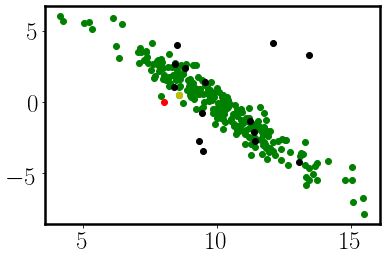

In [138]:
dataf = clfc.sample(1e3)
probsf = clfc.predict_proba(dataf[0][:,:])
distf = sqrt((Sun[0]-dataf[0][:,0])**2.0+(Sun[1]-dataf[0][:,1])**2.0+(Sun[2]-dataf[0][:,2])**2.0) 

mask = (argmax(probsf,axis=1)==0)
plt.scatter(dataf[0][mask,0],dataf[0][mask,2],c='g')

mask = (argmax(probsf,axis=1)==0)*(distf<1.0)
plt.scatter(dataf[0][mask,0],dataf[0][mask,2],c='y')

plt.scatter(x,z,c='k')
plt.plot(8.0,0.0,'ro')


In [131]:
sum(mask)

0

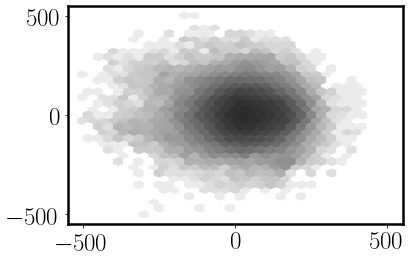

In [81]:
vmin = -500
vmax = 500
cmap = cm.gray_r
cmap.set_under('white', 1.0)
df_full = pandas.read_csv('../data/Gaia-SDSS.csv')
vx0 = df_full.GalRVel.values
vy0 = df_full.GalphiVel.values
vz0 = df_full.GalzVel.values
plt.hexbin(vy0,vz0,extent=(vmin,vmax,vmin,vmax),gridsize=30,cmap=cmap,vmin=1.0,vmax=6000.0,linewidths=1.0,bins='log',zorder=-10,alpha=1.0)


In [17]:
size(1)

1

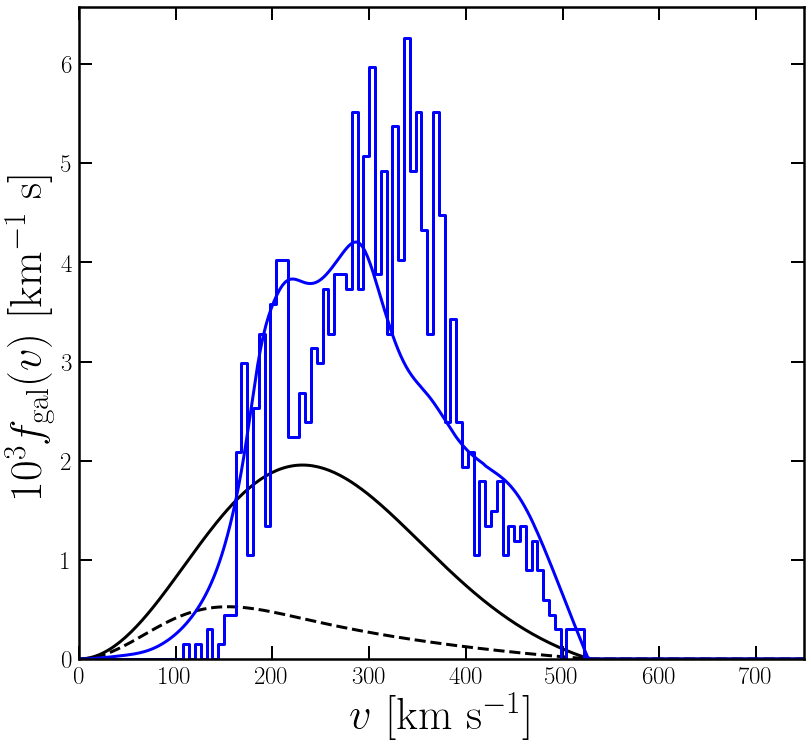

In [51]:
fig,ax = MySquarePlot(xlab,ylab1)
eta = 0.2

plt.plot(v,1e3*(1-xi_max)*(1-eta)*fv_Iso_gal,'k-',lw=3)
plt.plot(v,1e3*(1-xi_max)*eta*fv_Saus_gal,'k--',lw=3)


df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
all_names = names = df_S.group_id.unique()
df_sel = df_S
vv = sqrt((df_sel.GalRVel)**2.0+(df_sel.GalTVel)**2.0+(df_sel.GalzVel)**2.0)
fv,vbins = histogram(vv,bins=100,normed=True,range=(0,600))
plt.step(vbins[1:],1e3*fv,'-',color='b',lw=3)



# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
#weights = norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights = pops
weights /= sum(weights)


fv_gal1 = zeros(shape=n)
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv_gal1 += weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True,SmoothCutoff=SCO)

plt.plot(v,1e3*fv_gal1/trapz(fv_gal1,v),'b-',lw=3)

        



# df_highE = pandas.read_csv('../data/Gaia-SDSS_highE.csv')
# dfc = df_highE.loc[df_highE['feh'] < -1.4]
# vv = sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)
# fv,vbins = histogram(vv,bins=50,normed=True,range=(0,600))
# plt.plot(vbins[1:],1e3*fv*xi_max,'--',color='Crimson',lw=3)

# dfc = df_highE.loc[df_highE['feh'] < -2.0]
# vv = sqrt((dfc.GalRVel)**2.0+(dfc.GalphiVel)**2.0+(dfc.GalzVel)**2.0)
# fv,vbins = histogram(vv,bins=50,normed=True,range=(0,600))
# plt.plot(vbins[1:],1e3*fv*xi_max,'-',color='Crimson',lw=3)

plt.xlim([0,750])
ax.set_ylim(bottom=0.0)
plt.show()

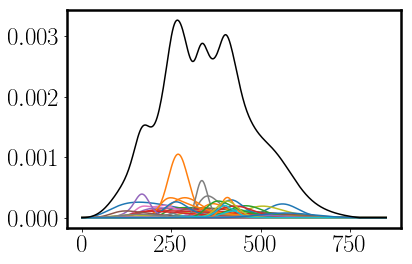

In [25]:
for i in range(0,nshards):
    plt.plot(v,fv_lab[i,:])
plt.plot(v,sum(fv_lab,0),'k-')
plt.show()

In [26]:
trapz(fvs_lab,v)

0.99999999999999989

In [33]:
x_meens,x_covs,v_meens,v_covs,fehs,pops,Psun = FitStars(df_sel)
print v_meens
print sqrt(sum(v_meens[0,:]**2.0))

[[  27.98272107 -275.08345117   17.98607471]]
277.087417021


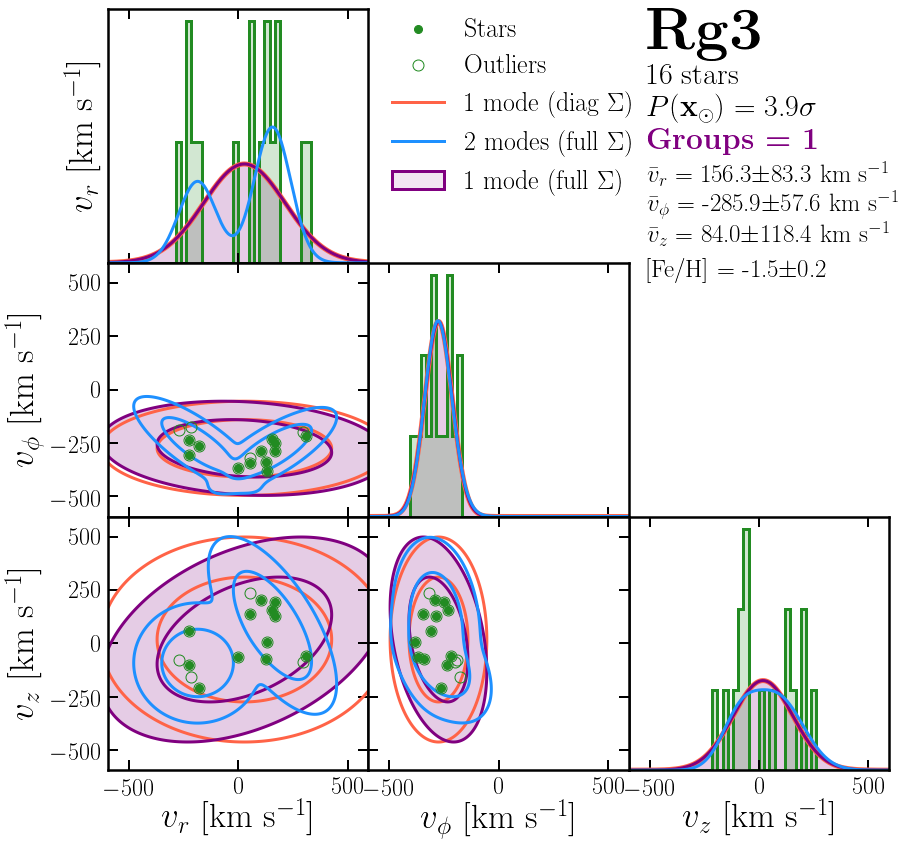

In [24]:
fig = VelocityTriangle(df_sel)
plt.show()